In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sympy as smp
import scienceplots
plt.style.use(['science','notebook'])

# 1. Introduction

The purpose of Monte Carlo simulation (MCS) is to simulate a real life experiment that depends on randomness to some extent. Below are some examples in the context of risk managment:

* An asset manager simulates **potential oil price paths (mean-reverting Ornstein-Uhlenbeck process)** to stress-test energy futures positions against commodity price crashes.

* A retail bank forecasts loan defaults by simulating **monthly default counts (binomial distribution)** and **loss amounts (lognormal distribution)** to estimate capital needs during economic downturns.

* An airline models IT system failures by simulating **outage frequency (Poisson distribution)** and **repair times (exponential distribution)** to optimize backup infrastructure budgets.

This file aims to introduce how to conduct MCS in Python. For most cases, the MCS process boils down into two steps: 

* Generating random variables according to a distribution; 

* Using those variables to conduct an experiment. 

In Section 2, we will demonstrate how to generate random variables according to a certain distribution. In Section 3, we will use an example to show how to utilize the generated random variables to conduct an experiment.

# 2. Generate Random Variables According to a Distribution
There are three common methods to generate random variables according to a certain distribution: using built-in functions, using analytical inverse of the distribution function, and retrieving from an empirical distribution. We will illustrate all three methods in this section. Afterwards, we will introduce a common method for generating correlated random variables.

#### 2.1 Simulating using built-in functions

One example: generating 1000 samples from a Rayleigh distribution.

In [6]:
r = np.random.rayleigh(size=1000)

Below is the sample distribution histogram:

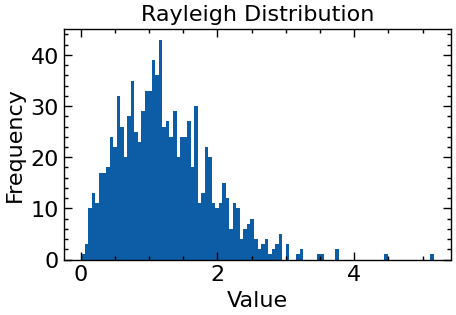

In [54]:
plt.figure(figsize=(5,3))
plt.hist(r, bins=100)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Rayleigh Distribution')
plt.show()

There are many other functions too. Check the description of numpy.random below.

In [52]:
np.random?

Type:        module
String form: <module 'numpy.random' from '/Users/youjing/.pyenv/versions/3.13.0/lib/python3.13/site-packages/numpy/random/__init__.py'>
File:        ~/.pyenv/versions/3.13.0/lib/python3.13/site-packages/numpy/random/__init__.py
Docstring:  
Random Number Generation

Use ``default_rng()`` to create a `Generator` and call its methods.

=============== =========================================================
Generator
--------------- ---------------------------------------------------------
Generator       Class implementing all of the random number distributions
default_rng     Default constructor for ``Generator``
=============== =========================================================

============================================= ===
BitGenerator Streams that work with Generator
--------------------------------------------- ---
MT19937
PCG64
PCG64DXSM
Philox
SFC64
============================================= ===

============================================= ===

#### 2.2 Simulating using a known inverse of the distribution function

Sometimes, there is not a built-in function for the distribution you want to generate from. If the cumulative distribution function (CDF) can be inverted analytically, you may use the method in this section to conduct the simulation. The principle of this method is given in the theorem below:

**Theorem:** If a random variable $X$ has a CDF of $F(x)$, then the variable $F^{-1}(U)$, where $U$ is a random uniform variable between 0 and 1, also has CDF $F(x)$. 

With this theorem, we can generate random numbers with CDF $F$ with the following steps:

* **Derive the inverse CDF**: Analytically solve $F(X)=y$ for $X$ to obtain $X=F^{-1}(y)$.

* **Generate uniform variables**: Use $U=RAND()$ in Excel to simulate $U \sim Uniform(0,1)$.

* **Apply the inverse CDF**: Substitute $U$ into $F^{-1}(U)$ to generate samples of $X$.

Below we use triangular distribution as an example.

If random variable $X$ has a triangular distribution with best case $b$, worst case $w$, and most likely case $m$, we will have the CDF below:

$$ F(X)=\left\{
\begin{aligned}
\frac{(X-w)^{2}}{(m-w)(b-w)}, & \quad if\quad w \le X <m\\
1-\frac{(b-X)^{2}}{(b-m)(b-w)}, & \quad if \quad m \le X \le b
\end{aligned}
\right.
$$
Denote $y = F(X)$. We can get the inverse of $F$ analytically:
$$ X = F^{-1}(y)=\left\{
\begin{aligned}
w+\sqrt{(m-w)(b-w)y},& \quad if \quad 0 \le y < \frac{m-w}{b-w}\\
b-\sqrt{(b-m)(b-w)(1-y)}, & \quad if \quad \frac{(m-w)}{b-w} \le y \le 1
\end{aligned}
\right.
$$

Simulate $y$ that is uniformly distributed between 0 and 1, we can get the triangular distributed $F^{-1}(y)$. Below is how it’s done in Python.




In [13]:
# Define the inverse CDF F^{-1}
def F_inv(y, b, w, m):
    if y < (m-w) / (b-w):
        return w + np.sqrt((m-w)*(b-w)*y)
    else:
        return b - np.sqrt((b-w)*(b-m)*(1-y))

In [ ]:
# Generate 10000 uniform random numbers (Us)
Us = np.random.rand(10000)

In [ ]:
# Substitute Us into the inverse CDF to get the triangular distributed random numbers (F_inv_Us)
# Assume b = 50, w = 10, m = 35
F_inv_Us = np.array([F_inv(U, b=50, w=10, m=35) for U in Us])


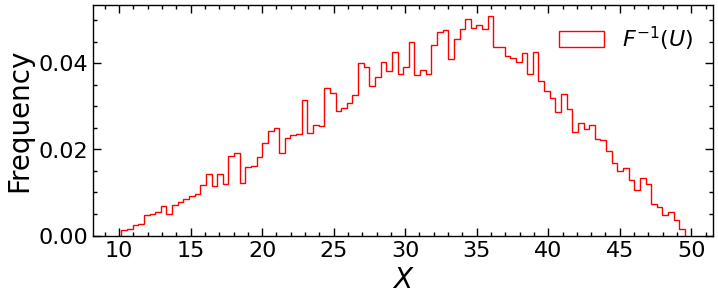

In [19]:
# Plot the histogram of the triangular distributed random numbers
plt.figure(figsize=(8,3))
plt.hist(F_inv_Us, histtype='step', color='red', density='norm', bins=100, label='$F^{-1}(U)$')
plt.legend()
plt.xlabel('$X$', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.legend()
plt.show()

#### 2.3 Simulating using an empirical distribution

When historical data lacks a clear theoretical distribution (e.g., stock returns with irregular patterns or operational delays with unique trends), you can simulate values directly from observed data. This approach is ideal when:

* No parametric distribution adequately fits the data.

* You need to preserve the exact statistical properties of historical outcomes.

Then you can use the following steps:

* Assume we have N periods of historical data. Store the historical data in one array. 


In [55]:
# In this example, N = 50000, and the historical data is normally distributed.
# In practice, you may use read_csv or read_excel function to read the historical data from a file.
his = np.random.normal(5, 1, 50000)

# Density function of this data
x = np.linspace(0, 8, 5000)
f_his = 1/np.sqrt(2*np.pi) * np.exp(-0.5*(x-5)**2)

* Simulate n random integers from $1$ to $N$.

In [56]:
# In this example, n=5000.
n = 5000
Us = np.random.randint(low=0, high=50000, size=n)


* Sampling from historical observations

In [57]:
sim_from_his = his[Us]

* Plot the histogram of the simulated sample

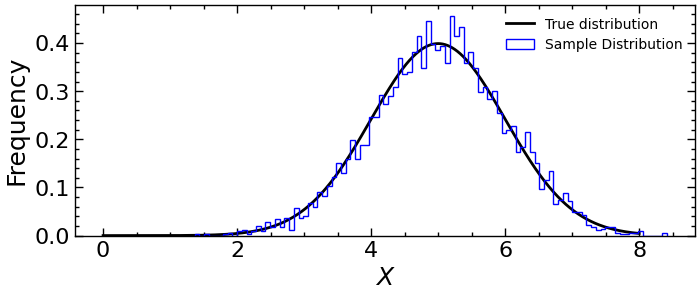

In [59]:
# In this example, we also plot the true underlying distribution. 
plt.figure(figsize=(8,3))
plt.plot(x, f_his, color='black', label='True distribution')
plt.hist(sim_from_his, histtype='step', color='blue', density='norm', bins=100, label='Sample Distribution')
plt.legend(loc="upper right", prop={'size': 10})
plt.xlabel('$X$', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.show()

#### 2.4 Simulating Correlated Random Variables
In this section, we will show how to use "np.where()" function to generate a random variable whose distribution depends on the realization of another variable. Consider the following example:

**Example:** RV1 is a random variable uniformly distributed between 0 and 10. RV2 is a normally-distributed random variable whose distribution depends on the realization of RV1. Specifically, if RV1 > 7, RV2 has mean 0 and std 5; otherwise, RV2 has mean 5 and std 2.

In [5]:
# Generate RV1 5000 times
RV1 = np.random.uniform(0, 10, size=5000)

# Generate RV2 5000 times based on the condition of RV1
RV2 = np.where(
    RV1 > 7, 
    np.random.normal(0, 5, size=5000), 
    np.random.normal(5, 2, size=5000)
    )

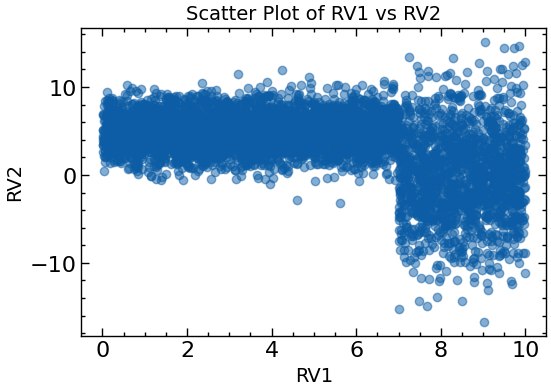

In [12]:
# Scatter plot of RV1 and RV2
plt.figure(figsize=(6, 4))
plt.scatter(RV1, RV2, alpha=0.5)
plt.xlabel('RV1', fontsize=14)
plt.ylabel('RV2', fontsize=14)
plt.title('Scatter Plot of RV1 vs RV2', fontsize=14)
plt.show()

# 3. Example: Simulating Lunch Bills at a Restaurant

In this section, We will use the example below to demonstrate how to utilize the generated random variables to conduct an experiment..

A restaurant would like to use a simulation model to analyze spending by customers. One lunch meal at this restaurant could have four components: drinks, main course, appetizer, and dessert. The owner has gathered the following data:

* **Drinks** spending is uniformly distributed between 1.50 and 6.00.

* A **main course** is ordered by 70 percent of customers. Among those who order a main course, their main course spending is normally distributed with a mean of 15 and a standard deviation of 3.

* An **appetizer** is ordered by 30 percent of customers whose drinking bills are greater than 4.00, and 20 percent of customers whose drinking bills do not exceed 4.00. Among those who order an appetizer, their appetizer spending is normally distributed with a mean of 8 and a standard deviation of 2.

* A **dessert** is ordered by 20 percent of customers. Each day, three desserts are offered, priced at 3.50, 4.00, and 6.00. Customers are equally likely to order any one of these desserts.

We want to simulate 5000 trials of the lunch bills, and plot out the distribution. The steps are as follows:

In [ ]:
# Simulate 5000 times
N = 5000

# Drinks spending
drinks = np.random.uniform(1.5, 6, size=N)

# Determine if a main course is ordered
if_main_course = np.random.choice([0, 1], size=N, p=[0.3, 0.7])

# Main course spending
main_course = if_main_course * np.random.normal(15, 3, size=N)

# Determine if an appetizer is ordered based on the drinking bill
if_appetizer = np.where(drinks > 4, 
                        np.random.choice([0, 1], size=N, p=[0.7, 0.3]), 
                        np.random.choice([0, 1], size=N, p=[0.8, 0.2]))

# Appetizer spending
appetizer = if_appetizer * np.random.normal(8, 2, size=N)

# Determine if a dessert is ordered
if_dessert = np.random.choice([0, 1], size=N, p=[0.8, 0.2])

# Dessert prices
dessert_prices = [3.5, 4.0, 6.0]

# Dessert spending
dessert = if_dessert * np.random.choice(dessert_prices, size=N)

# Total spending
total_spending = drinks + main_course + appetizer + dessert


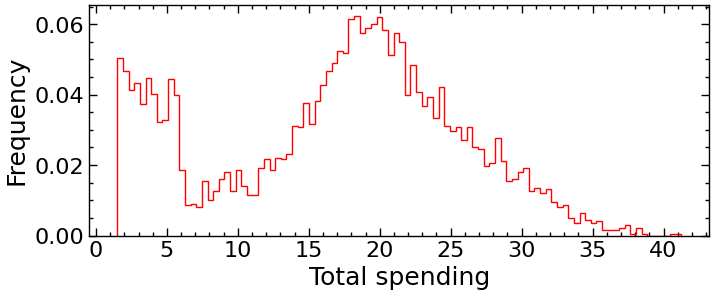

In [50]:
# Plot the histogram of the total spending
plt.figure(figsize=(8,3))
plt.hist(total_spending, histtype='step', color='red', density='norm', bins=100)
plt.xlabel('Total spending', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.show()

In this case, the variable of interest is total spending, which is a simple sum of four random components. While this demo uses basic arithmetic for simplicity, real-world risk models often involve more complex transformations (e.g., logarithmic returns, conditional thresholds) or interdependent systems (e.g., correlated asset prices, cascading failures). Regardless of complexity, the main idea remains unchanged: propagate uncertainty through your model by applying calculations to your simulated variables.

Once simulations are complete, you can analyze the simulated values with appropriate statistical tools. You may: 

* Quantify central tendencies (mean, median) and dispersion (variance, standard deviation).

* Estimate tail risks using percentile-based metrics (e.g., 95% VaR).

* Visualize outcome distributions through histograms or kernel density plots.

* Perform sensitivity analysis to identify dominant risk drivers.